## Programming Exercise 4: Neural Networks Learning

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
#import scipy.misc.toimage #scipy.misc.toimage
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function

### 1 Neural Networks

#### 1.1 Visualizing the data

In [2]:
datafile = 'data/ex4data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
X = np.insert(X,0,1,axis=1)
print ("'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [3]:
mat['X'][0].reshape(20,20)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00

In [4]:
len(X[0][1:])

400

In [5]:
len(X[0][2:])

399

In [6]:
unique, counts = np.unique(y, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  1 500]
 [  2 500]
 [  3 500]
 [  4 500]
 [  5 500]
 [  6 500]
 [  7 500]
 [  8 500]
 [  9 500]
 [ 10 500]]


In [7]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

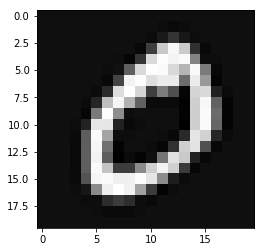

In [8]:
plt.imshow(getDatumImg(X[0]),cmap=cm.Greys_r)

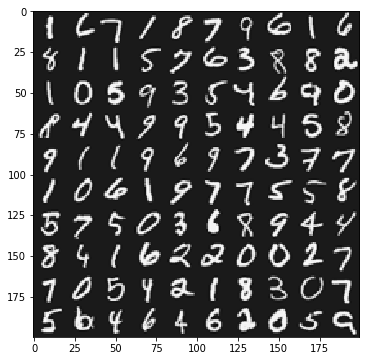

In [9]:
displayData()

#### 1.2 Model representation

![](https://camo.githubusercontent.com/e1e638bc1cc37d2ee7465a475ffb7614eb486f0d/687474703a2f2f692e696d6775722e636f6d2f794a4a466d45582e6a7067)

- $\theta_1$ has size `25 x 401`
- $\theta_2$ has size `10 x 26`
- `X` has size `5000 x 401`
- `Y` has size `5000 x 1`

In [10]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex4weights.mat
datafile = 'data/ex4weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
# The matrices Theta1 and Theta2 will now be in your workspace
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26

In [11]:
Theta1.shape

(25, 401)

In [12]:
Theta2.shape

(10, 26)

In [13]:
#바이어스가 없는 각각의 레이어 사이즈를 의미한다.
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [14]:
# fmin_cg의 속도를 위해서 flatten을 수행 한다.

def flattenParams(thetas_list):
    """
    들어온 list에 저장된 matrix를 평평한 n by 1 matrix로 변경 한다.
    myThetas가 아래와 같이 2개의 theta에 대해서 저장하고 있다면 1개의 flatten한 matrix를 반환하게 된다.
    [25x401 + 10x26] = [10285]
    """
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    # flatten하게 만든 theta를 복구 하는 것이다. 
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
        
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

#### 1.3 Feedforward and cost function

**Cost Function**
$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

- K=10 이다. (0,1,2,...9) 출력값 Logistic regression
따라서 참 값은 1열에 0,1,2,3와 같이 정수로 적혀있는 Label 데이터를 cost 계산을 위해서 vector로 표현 해야 한다.

![](https://camo.githubusercontent.com/fb7b2d0b32d1b53b2d625de480925d06789e8dd1/687474703a2f2f692e696d6775722e636f6d2f4e77584f4a4e4e2e6a7067)

**Regularized Cost Function**
$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m=5000}\sum_{k=1}^{K=10}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [15]:
def computeCost(mythetas_flattened, myX_flattened, myy, mylambda=0.):
    """
    인풋 1) bias를 포함하는 theta 모음 
         2) training X를 입력 받는다.
         3) labeled vector y는 one column 이다.
         
    Linear algebra version은 꽤 복잡하다.
    아래는 그냥 loop를 이용한 방법이다.
        1) y vector는 10 row에 1 column을 가지고 있다.
        2) 주어진 training point에 대한 y vector와의 cost를 계산 한다.
        3) 모든 코스트를 누적한다.
        4) regularization은 loop를 모두 다 수행한 후에 한다.
    """
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)
    
    total_cost = 0. # training data 전부에 대한 cost를 누적하게 된다. 
    m = n_training_samples # 5000

    for irow in range(m):
        myrow = myX[irow] # 401 x 1, 1개의 입력 이미지이다. bias를 포함해서 401 이다.
                
        # (zs, activiation)을 각각에 레이어에 대해서 리턴한다.
        # [-1][1]은 마지막 레이어에서의 activiation(a)을 의미 한다. 
        myhs = propagateForward(myrow,mythetas)[-1][1]

        # 10x1을 저장한 `y` vector는 `1`이 하나있고 나머진 모두 `0`인 vector이다.
        # 여기서 10번째가 1이면 이것은 digit number가 0일 때를 의미한다 (matlab과의 호환 때문)
        # 원래 data form은 1,2,3,~10 이런식으로 저장되어 있는것을 vector에 해당하는 숫자 순서에 1인 형태로 변경 하는 것이다. 
        tmpy  = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        
        # Cost를 계산 한다 (Cross Entropy)
        # Vectorized operation이므로 K=10으로 연산이 된것이다. 
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
     
        # training data 1개에 대한 cost를 누적해서 더한다.
        total_cost += mycost
  
    # Normalize the total_cost, cast as float (평균 Cost 계산)
    # cumulated cost / 5000
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for mytheta in mythetas:
        total_reg += np.sum(mytheta*mytheta) #element-wise multiplication
    total_reg *= float(mylambda)/(2*m)
        
    return total_cost + total_reg
       

![](https://camo.githubusercontent.com/e1e638bc1cc37d2ee7465a475ffb7614eb486f0d/687474703a2f2f692e696d6775722e636f6d2f794a4a466d45582e6a7067)

In [17]:
def propagateForward(row,Thetas):
    """
    입력들은 not flattened 이다.
    row와 Thetas는 bias를 이미 포함하고 있다.
    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    ***The 'activations' are the same as "h", but this works for many layers
    (hence a vector of thetas, not just one theta)
    Also, "h" is vectorized to do all rows at once...
    this function takes in one row at a time***
    """
   
    features = row
    zs_as_per_layer = []
    for i in range(len(Thetas)):  
        Theta = Thetas[i]
        # Theta는 (25,401) 과 (10, 26) 이렇게 2개이다.
        # features는 입력이므로 (401,1) 이다.
        # 첫 번째 z는 (25,1)로 연산된다.
        # bias는 계속 1이기 때문에 forward 에서는 counting 하지 않는다. 
        # 입력은 (25 by 401) x (401 by 1) // 출력은 (25 by 1)
        # 마지막에 구지 reshape을 해주는것은 
        # 단순 array를 X by 1 형태의 matrix로 바꿔주기 위함이다.
        z = Theta.dot(features).reshape((Theta.shape[0],1)) 
        #z = Theta.dot(features) # 이렇게하면 backpropagation 때 에러가 발생한다.
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer) # tuple(zs, as)을 리턴
        
        a = np.insert(a,0,1) #Add the bias unit
        features = a

In [18]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#you should see that the cost is about 0.287629
myThetas = [ Theta1, Theta2 ]

#Note I flatten the thetas vector before handing it to the computeCost routine,
#as per the input format of the computeCost function.
#It does the unrolling/reshaping itself
#I also flatten the X vector, similarly
print (computeCost(flattenParams(myThetas),flattenX(X),y))

0.287629165161


In [19]:
mythetas = reshapeParams(flattenParams(myThetas))
print(mythetas[0].shape)

(25, 401)


In [20]:
print(flattenParams(myThetas).shape)
print(n_training_samples)

(10285, 1)
5000


In [21]:
print(myThetas[0].shape)
print(myThetas[1].shape)

(25, 401)
(10, 26)


In [22]:
X[0,:].shape

(401,)

In [23]:
#z = myThetas[0].dot(X[0]).reshape((myThetas[0].shape[0],1))
z = myThetas[0].dot(X[0].reshape(401,1))
z

array([[-2.93684669],
       [-2.45058587],
       [ 4.95510333],
       [ 0.07492977],
       [ 0.87241676],
       [ 5.65014719],
       [-4.52318577],
       [-6.41596864],
       [ 5.65121414],
       [-3.87156641],
       [-2.55955558],
       [-3.81033274],
       [-3.02761383],
       [-2.9383968 ],
       [-5.46421117],
       [ 2.06051863],
       [ 4.82088856],
       [-2.23170382],
       [ 1.71790599],
       [ 1.37208071],
       [-3.71293077],
       [ 4.10936639],
       [ 3.56635593],
       [ 2.81388641],
       [-2.1195223 ]])

In [24]:
X.shape# 들어가는 입력을 한번 알아봄 

(5000, 401)

In [25]:
myhs = propagateForward(X[0],myThetas)[-1][1] # Last activation value 이다. 
myhs

array([[  1.12661530e-04],
       [  1.74127856e-03],
       [  2.52696959e-03],
       [  1.84032321e-05],
       [  9.36263860e-03],
       [  3.99270267e-03],
       [  5.51517524e-03],
       [  4.01468105e-04],
       [  6.48072305e-03],
       [  9.95734012e-01]])

In [26]:
tmpy = np.zeros((10,1))
tmpy[y[300]-1] = 1
tmpy

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.]])

In [27]:
mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
mycost

array([[ 0.03452039]])

#### 1.4 Regularized cost function

In [28]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#and lambda = 1, you should see that the cost is about 0.383770
myThetas = [ Theta1, Theta2 ]
print (computeCost(flattenParams(myThetas),flattenX(X),y,mylambda=1.))

0.384487796243


### 2 Backpropagation

#### 2.1 Sigmoid gradient

![](https://camo.githubusercontent.com/89121a45bde7fbd1af2b420871113424def7eb23/687474703a2f2f692e696d6775722e636f6d2f616b65424743712e706e67)

$$g(z) = \frac{1}{1+e^{-z}}$$

$$g'(z) = g(z)(1 - g(z))$$

In [29]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

In [30]:
print(sigmoidGradient(5))
print(sigmoidGradient(0))
print(sigmoidGradient(-5))

0.00664805667079
0.25
0.00664805667079


#### 2.2 Random initialization

Weight들을 zero로 초기화 하면 `neural network`이 제대로 학습 되지 않는다.  
모든 노드들이 매번 같은 값으로 backpropagation에 의해서 update이 되기 때문이다.  
따라서 아래와 같이 $\Theta^{(l)}_{ij}$의 값을 $[-\epsilon,\epsilon]$ 사이의 값으로 초기화 한다.

In [31]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 2.3 Backpropagation


![](https://camo.githubusercontent.com/4217320c6888fabbb9366fa9565cfee64b5dae37/687474703a2f2f692e696d6775722e636f6d2f734a644c49375a2e6a7067)

$$\delta^{(l)} = ((\Theta^{(l)})^T \delta^{(l+1)})\ .*\ g'(z^{(l)})$$

** 함수의 입력값 **  
- mythetas_flattened <- flattenParams(myThetas), 구하고자하는 2개의 $\theta$를 담고있다.
- myX_flattened <- flattenX(X), 입력된 이미지값 20x20+1(bias)
- myy <- y, 참값
- mylambda=0. <- 정규화의 수치


In [32]:
def backPropagate(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)

    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in range(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(myrow,mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1 # 이 부분 이해가 안됬었는데 이해가 됨. 이건 bias를 넣는 부분이 아니다. 1,2,3,4~10 값을 [0,1,0..] 형식
        delta3 = a3 - tmpy 
        delta2 = mythetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2) # remove 0th element
        a2 = np.insert(a2,0,1,axis=0)
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(mylambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(mylambda)/m)*mythetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [33]:
#%%timeit -n1 -r1
#Actually compute D matrices for the Thetas provided
flattenedD1D2 = backPropagate(flattenParams(myThetas),flattenX(X),y,mylambda=0.)
D1, D2 = reshapeParams(flattenedD1D2)
print(D1.shape)
print(D2.shape)

(25, 401)
(10, 26)


#### 2.4 Gradient checking

Backpropagation을 안쓰고 `Numerical computing`을 이용해서 `approximate derivative of cost function`아래와 같이 구할 수 있다.  

$$\dfrac{\partial}{\partial\Theta}J(\Theta) \approx \dfrac{J(\Theta + \epsilon) - J(\Theta - \epsilon)}{2\epsilon}$$

특정 $\theta_{j}$에 대해서는 아래와 같다.
$$\dfrac{\partial}{\partial\Theta_j}J(\Theta) \approx \dfrac{J(\Theta_1, \dots, \Theta_j + \epsilon, \dots, \Theta_n) - J(\Theta_1, \dots, \Theta_j - \epsilon, \dots, \Theta_n)}{2\epsilon}$$

보통 $\epsilon$은 $10^{-4}$정도는 해야 안정적이다. 너무 작으면 numerical problem이 생긴다.  
하지만 이 방법은 `Backpropagation`이 잘 구현 됬는지 Debugging 용도로 쓰는 것이다.   
연산속도가 매우 느리기 때문이다.

In [48]:
def checkGradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = computeCost(flattened + epsvec,myX_flattened,myy,mylambda)
        cost_low  = computeCost(flattened - epsvec,myX_flattened,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print ("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x]))

In [49]:
D1

array([[  6.18712766e-05,   0.00000000e+00,   0.00000000e+00, ...,
          9.70102410e-09,   2.85541159e-09,   0.00000000e+00],
       [  9.38798109e-05,   0.00000000e+00,   0.00000000e+00, ...,
          3.22774693e-08,  -1.26316319e-10,   0.00000000e+00],
       [ -1.92593606e-04,   0.00000000e+00,   0.00000000e+00, ...,
          7.05404498e-08,   1.41584916e-09,   0.00000000e+00],
       ..., 
       [  6.60569302e-05,   0.00000000e+00,   0.00000000e+00, ...,
         -1.40472252e-08,   1.94786057e-09,   0.00000000e+00],
       [  2.90522062e-04,   0.00000000e+00,   0.00000000e+00, ...,
          5.06149568e-07,  -5.54722494e-08,   0.00000000e+00],
       [ -6.33753316e-05,   0.00000000e+00,   0.00000000e+00, ...,
          5.05491848e-09,   4.46821993e-09,   0.00000000e+00]])

In [50]:
#%%timeit -n1 -r1
checkGradient(myThetas,[D1, D2],X,y)

Element: 5726. Numerical Gradient = 0.000284. BackProp Gradient = 0.000284.
Element: 2592. Numerical Gradient = 0.000176. BackProp Gradient = 0.000176.
Element: 6250. Numerical Gradient = 0.000085. BackProp Gradient = 0.000085.
Element: 10158. Numerical Gradient = -0.000071. BackProp Gradient = -0.000071.
Element: 1771. Numerical Gradient = 0.000261. BackProp Gradient = 0.000261.
Element: 2015. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.
Element: 10029. Numerical Gradient = 0.000732. BackProp Gradient = 0.000732.
Element: 2473. Numerical Gradient = 0.000129. BackProp Gradient = 0.000129.
Element: 3786. Numerical Gradient = 0.000040. BackProp Gradient = 0.000040.
Element: 4532. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.


#### 2.5 Regularized Neural Networks

이미 back propagation 할 때 `Regularization term`을 입력 했다.  
따라서 따로 구현할 것은 없다.

#### 2.5 Learning parameters using fmincg

fmin_cg함수를 이용해서 학습을 수행  
- Minimize a function using a nonlinear conjugate gradient algorithm.

장점
- No need to manually pick α.
- inter-loop를 돌면서 최적의 learning rate을 스스로 매번 다르게 결정한다.
- Often faster than gradient descent.

단점
- More complex.

In [51]:
#Here I will use scipy.optimize.fmin_cg

def trainNN(mylambda=0.):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,mylambda),maxiter=50,disp=True,full_output=True)
    return reshapeParams(result[0])

In [52]:
#Training the NN takes about ~70-80 seconds on my machine
learned_Thetas = trainNN()

         Current function value: 0.286438
         Iterations: 50
         Function evaluations: 121
         Gradient evaluations: 121


만약 제대로 구현 했다면 training accuracy는 `95.3%` 정도가 나온다.  
Random initialization 때문에 local minimum이 약간 변동하고 1%의 변동은 있을 수 있다.

In [53]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = [1,2,3,4,5,6,7,8,9,10]
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in range(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print ("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))

In [58]:
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 96.8%


In [55]:
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = trainNN(mylambda=10.)

         Current function value: 1.076550
         Iterations: 50
         Function evaluations: 115
         Gradient evaluations: 115


In [71]:
computeAccuracy(X,learned_regularized_Thetas,y)

Training set accuracy: 93.0%


#### 2.6 잘 예측된 것과 잘못 prediction된 image 찾아 보기

In [65]:
# 이미 구해진 optimal theta: myThetas
n_correct, n_total = 0., 0.
correct_indices = []
incorrect_indices = []

for irow in range(X.shape[0]):
    n_total += 1
    if predictNN(X[irow],learned_Thetas) == int(y[irow]):
        correct_indices.append(irow)
        n_correct += 1
    else: incorrect_indices.append(irow) # 잘못 예측한것들을 누적 한다. 
print ("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 96.8%


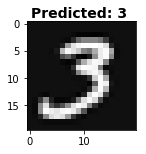

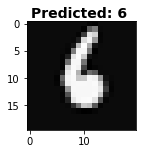

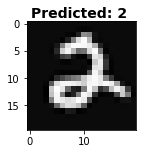

In [69]:
#Pick some of the images we clasified in right way
for x in range(3):
    i = random.choice(correct_indices)
    fig = plt.figure(figsize=(2,2))
    img = scipy.misc.toimage(getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],learned_Thetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')

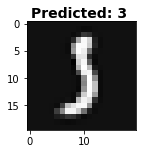

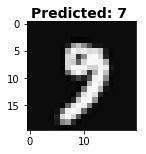

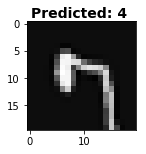

In [70]:
#Pick some of the images we got WRONG and look at them, just to see
for x in range(3):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(2,2))
    img = scipy.misc.toimage(getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],learned_Thetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')

### 3 Visualizing the hidden layer

In [72]:
def displayHiddenLayer(myTheta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    myTheta = myTheta[:,1:]
    assert myTheta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

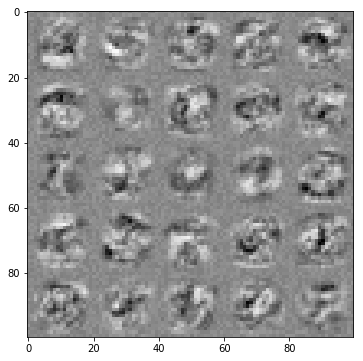

In [73]:
displayHiddenLayer(learned_Thetas[0])